In [87]:
import h5py
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
from sklearn.decomposition import PCA
from aging.plotting import figure, format_plots, legend
from scipy.spatial.distance import pdist, squareform

In [2]:
format_plots()

In [3]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/longtogeny_males_session_dynamics_clean.parquet')
# df = df[df.index.get_level_values('age') < 600]
ages = df.index.get_level_values('age')

In [5]:
exclude_dates = [pd.Timestamp('2021-10-16 17:00:57')]

In [6]:
df = df[~df.index.get_level_values('date').isin(exclude_dates)]

In [7]:
session_exclusion_list = '/n/groups/datta/win/longtogeny/data/metadata/Ontogeny experiment list - Session quality control.csv'
exclusion_df = pd.read_csv(session_exclusion_list, header=0)

exclusion_df['Keep?'] = exclusion_df['Keep?'].str.lower()
exclusions = exclusion_df.query('`Keep?` != "y"')
exclusion_df['Keep?'].unique()

array(['y', 'n', '?'], dtype=object)

In [8]:
exclusions.head()

File path Checked? Keep?  \
3  /n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...        y     n   
4  /n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...        y     n   
5  /n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...        y     n   
6  /n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...        y     n   
7  /n/groups/datta/Dana/Ontogeny/raw_data/Ontogen...        y     n   

                                      Issue  
3  fading, noise, further inspection needed  
4                                     noise  
5                                wall noise  
6                       replaced with noise  
7                                wall noise

In [9]:
exclude_uuid = []
for idx, row in exclusions.iterrows():
    with h5py.File(row['File path'], 'r') as h5f:
        uuid = h5f['metadata/uuid'][()].decode()
        exclude_uuid.append(uuid)

In [10]:
mask = ~df.index.get_level_values('uuid').isin(exclude_uuid)

In [11]:
df = df[mask]

In [12]:
outliers = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/male_long_outlier_sessions.parquet')

outlier_uuids = outliers.index.get_level_values('uuid')

In [13]:
df = df[~df.index.get_level_values('uuid').isin(outlier_uuids)]

In [15]:
norm_df = np.log(df + 1e-6)

In [14]:
def zscore(arr):
    return (arr - np.mean(arr, axis=0, keepdims=True)) / np.std(arr, axis=0, keepdims=True)

In [34]:
pca = PCA()
pcs = pca.fit_transform(df)[:, :100]

In [35]:
np.sum(np.cumsum(pca.explained_variance_ratio_) < 0.9)

206

In [36]:
# distances = squareform(pdist(df.loc[:, keep_sylls].to_numpy(), metric="jensenshannon"))
# distances = squareform(pdist(zscore(df.to_numpy()), metric="euclidean"))
distances = squareform(pdist(pcs, metric="euclidean"))
nn = np.argsort(distances, axis=1)

In [37]:
# plt.imshow(distances)

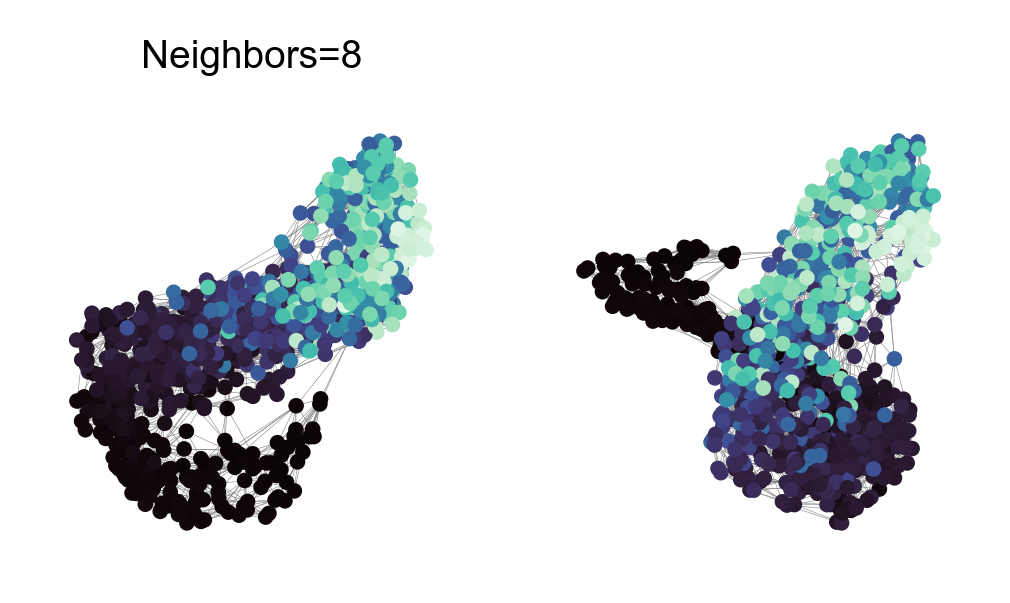

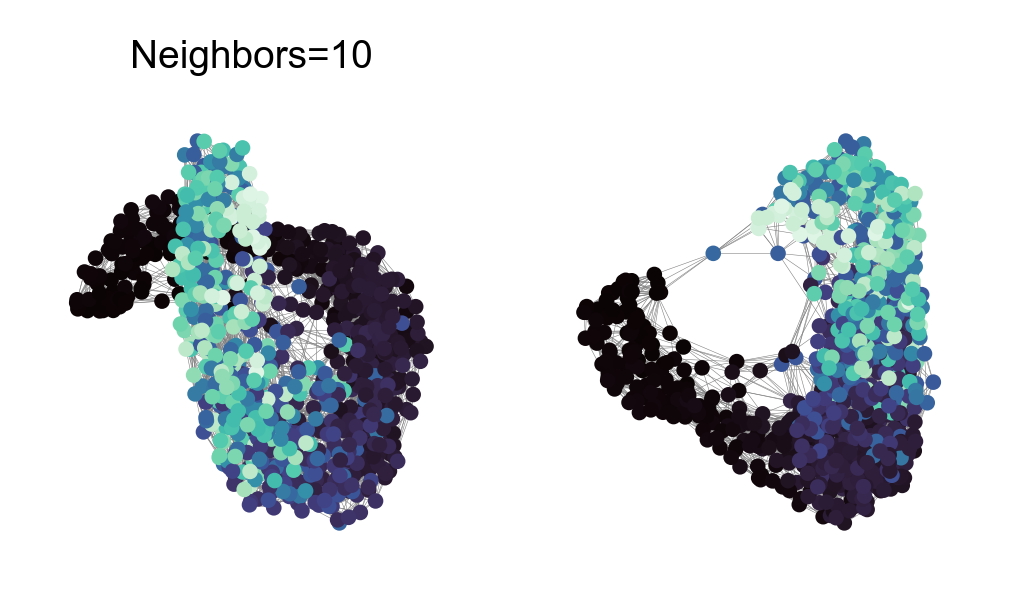

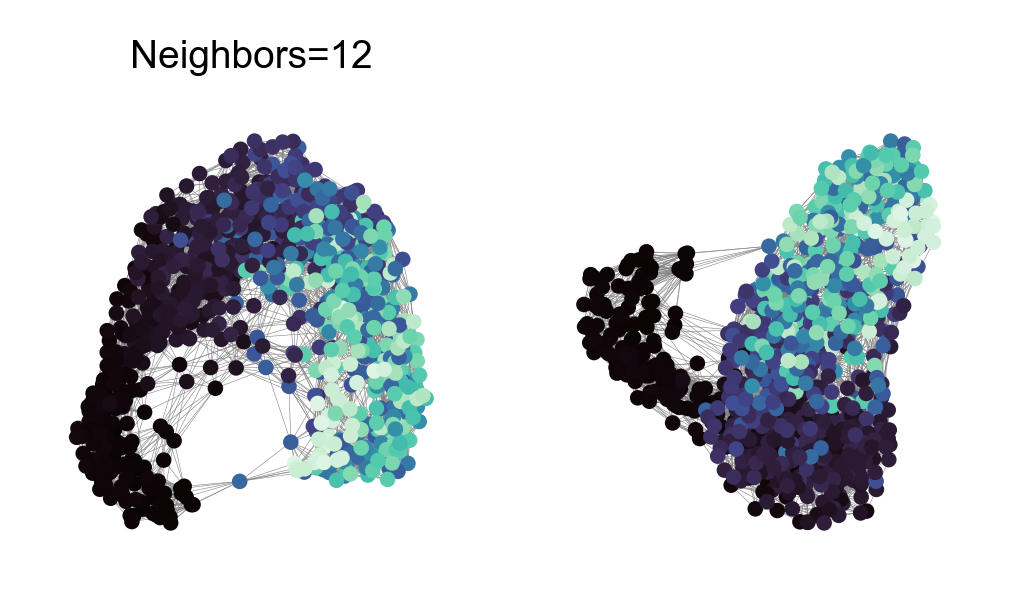

In [67]:
width = 1.5
n_cols = 2
# for k_neigh in [9]:
for k_neigh in range(8, 14, 2):
    indices = nn[:, :k_neigh + 1]

    graph = nx.Graph()
    edges = []
    for row in indices:
        i = row[0]
        for j in row[1:]:
            edges.append((i, j, distances[i, j]))
            # edges.append((i, j))
    graph.add_weighted_edges_from(edges)
    # graph.add_edges_from(edges)
    colors = [ages[i] for i in graph.nodes]

    fig, ax = plt.subplots(1, n_cols, figsize=(n_cols * width, 1.5))
    for i, a in enumerate(ax.flat):
        pos = nx.spring_layout(graph, seed=i)
        nx.draw(
            graph,
            pos=pos,
            node_size=4,
            width=0.1,
            edge_color="gray",
            node_color=colors,
            arrows=False,
            ax=a,
            cmap="mako",
        )
    ax[0].set(title=f"Neighbors={k_neigh}")
    plt.show()

## Run pseudotime diffusion

In [39]:
from scipy.stats import spearmanr, rankdata
from sklearn.preprocessing import LabelEncoder
import colorcet as cc

In [40]:
def mm_norm(x):
    return (x - x.min()) / np.ptp(x)

In [41]:
k_neigh = 10

a = np.zeros_like(distances)
a[np.arange(len(a))[:, None], nn[:, :k_neigh + 1]] = 1 / k_neigh

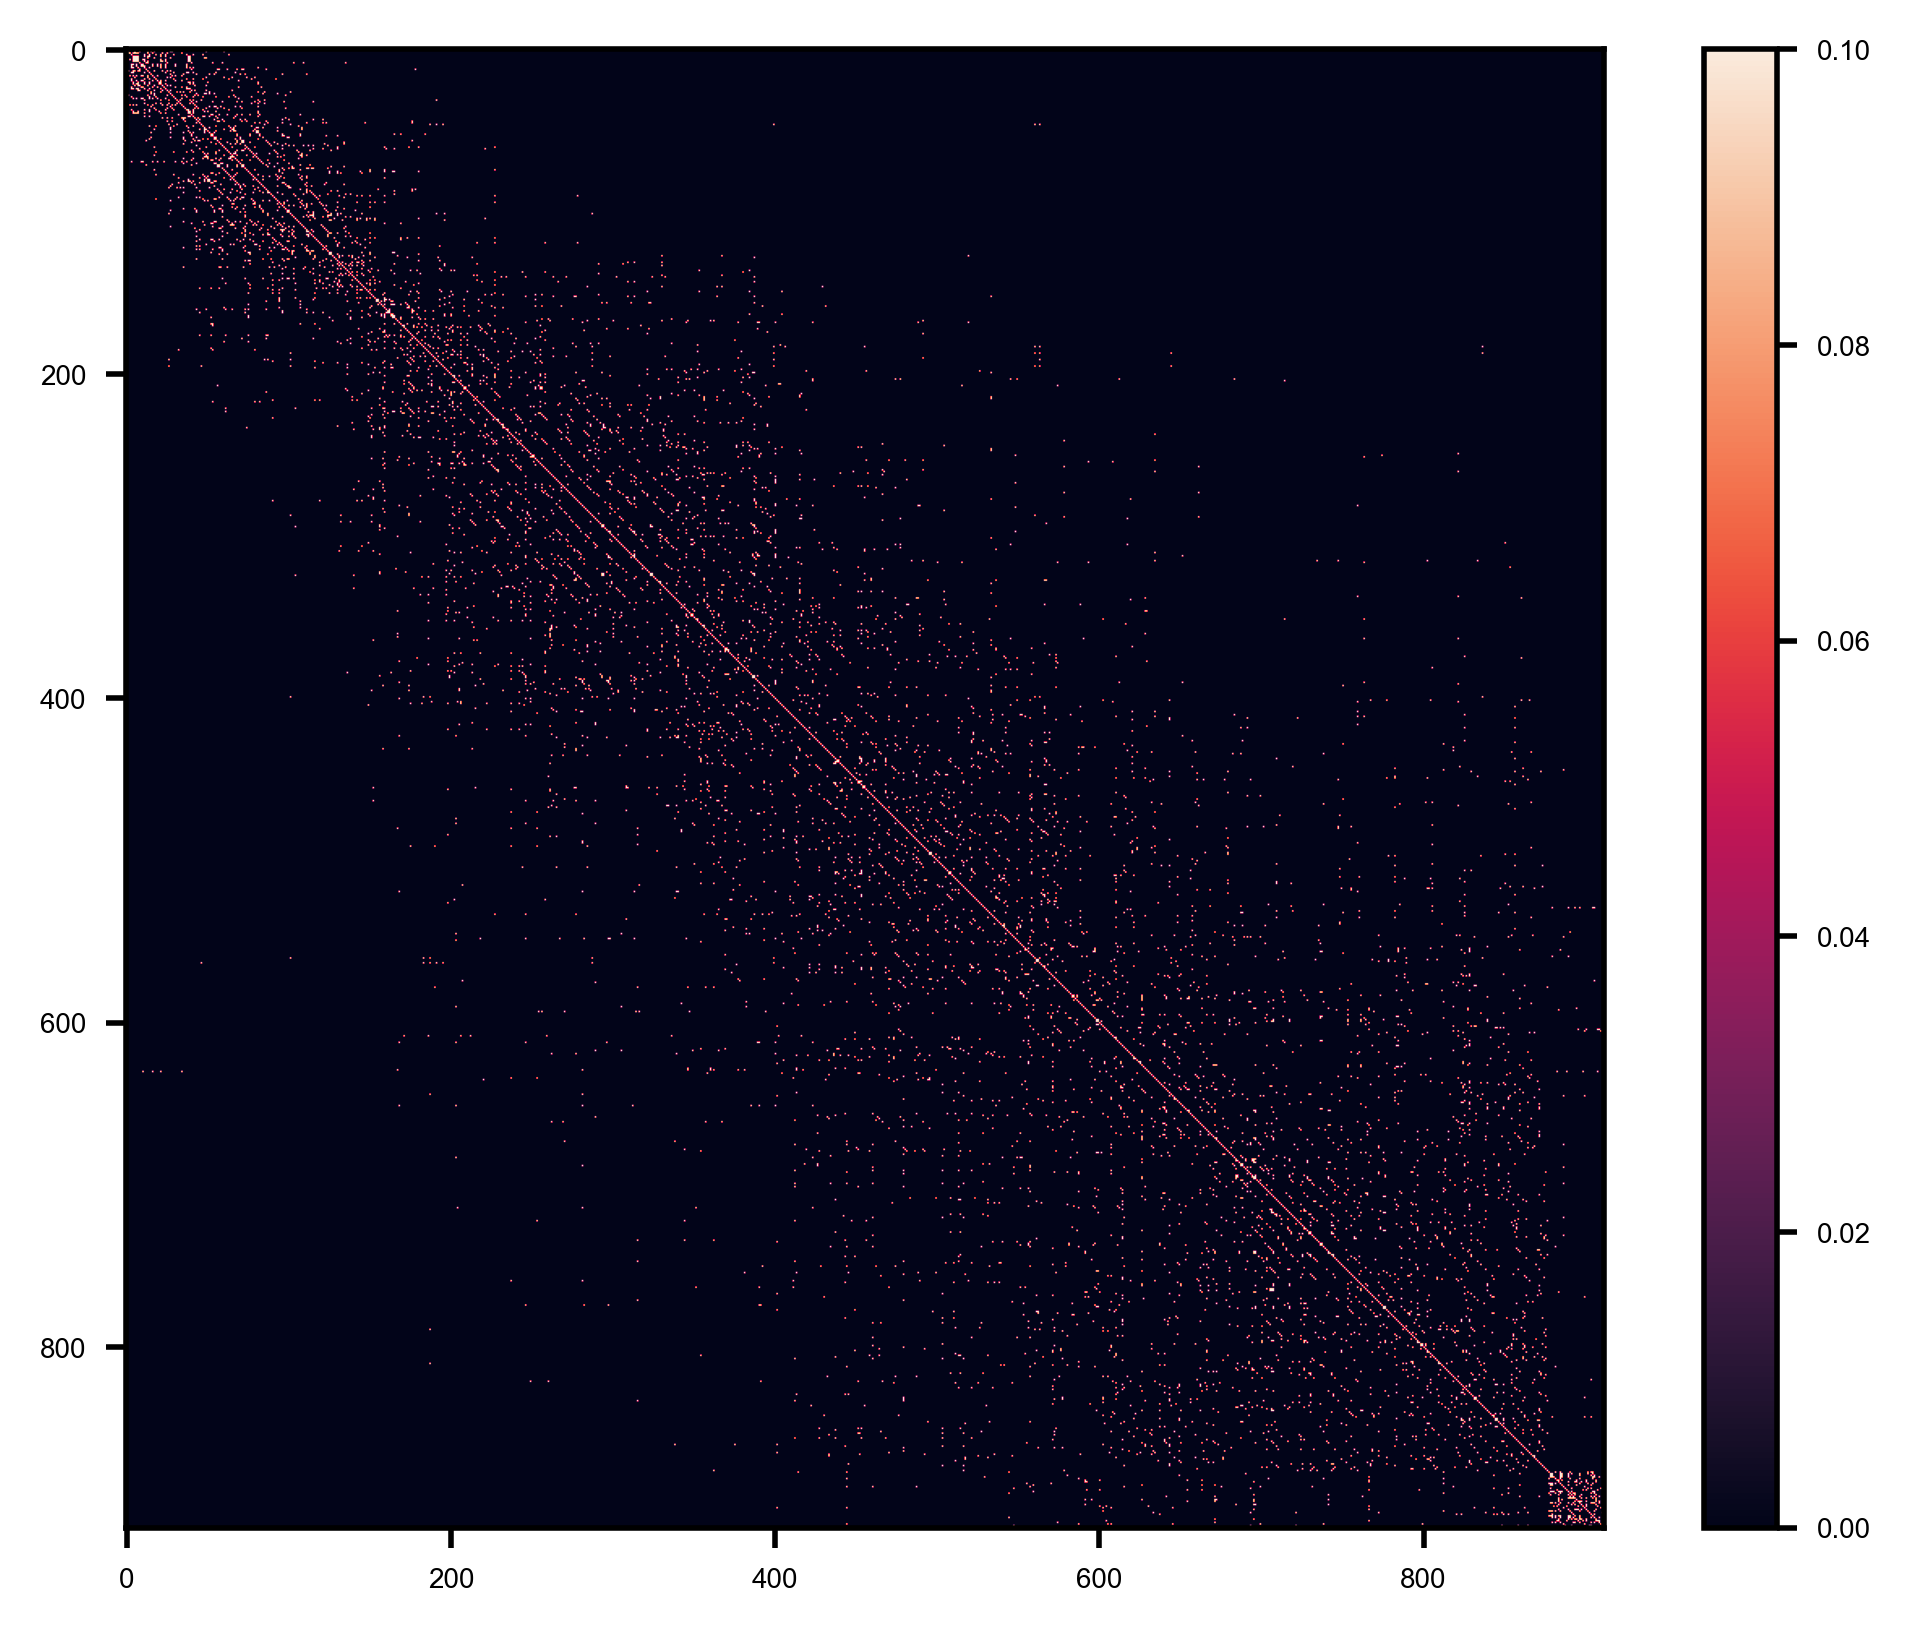

In [42]:
plt.imshow(a)
plt.colorbar()

In [43]:
beta = 0.1
smoother = np.eye(len(a)) * beta * a + (1 - beta) * a

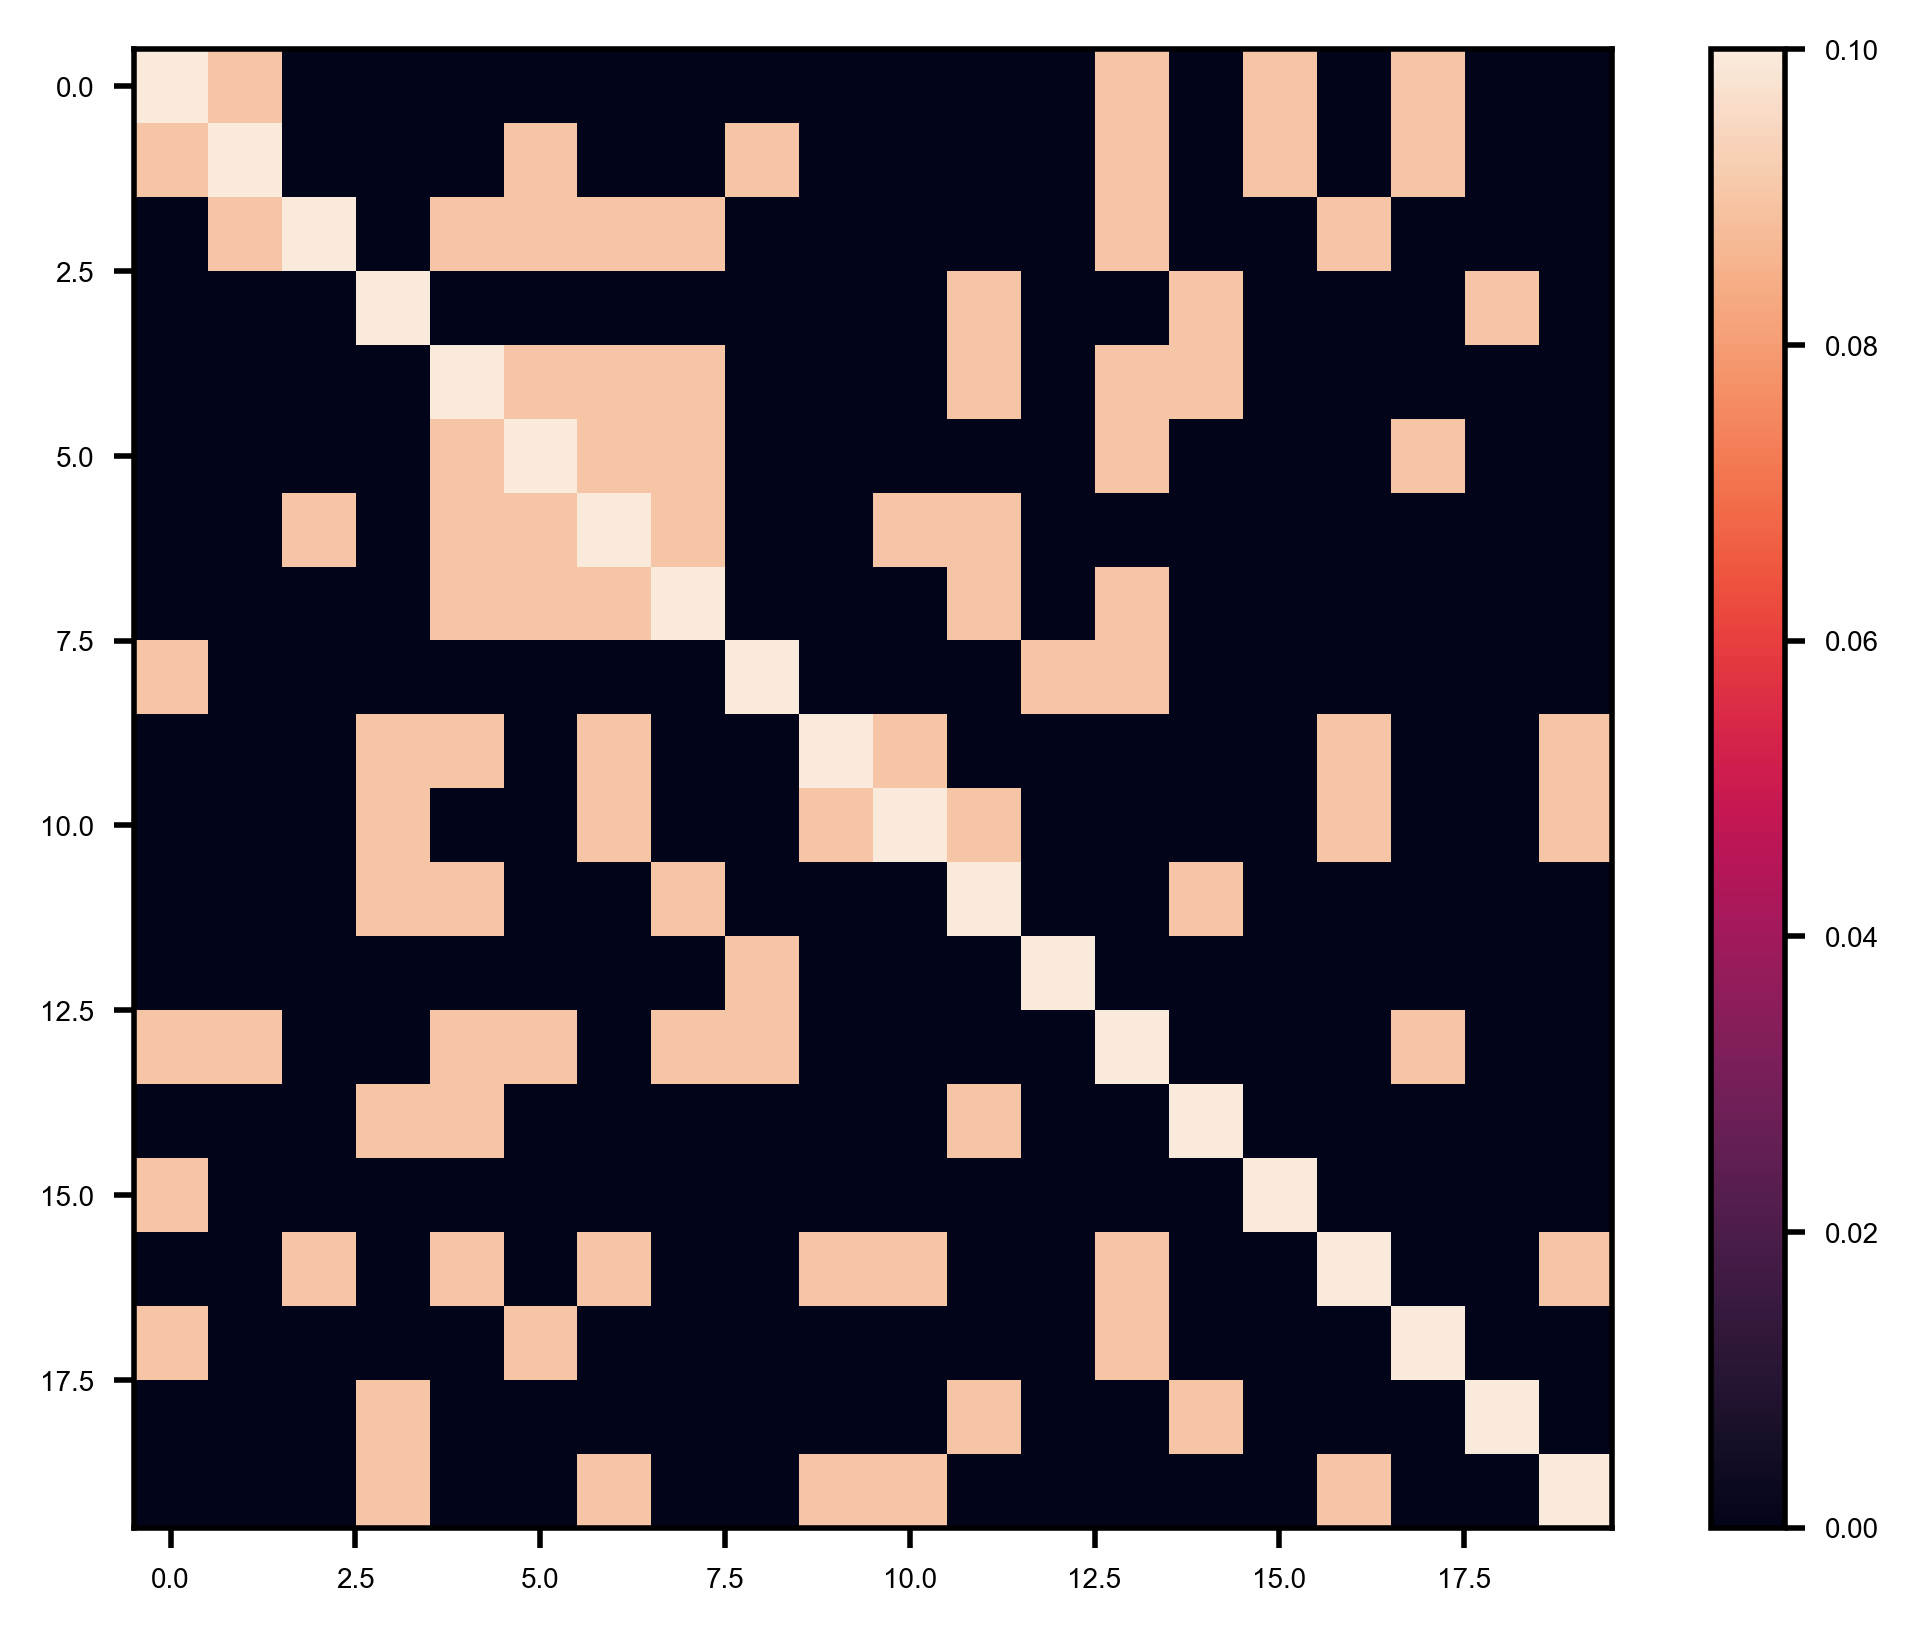

In [44]:
plt.imshow(smoother[:20, :20], interpolation='none')
plt.colorbar()

In [45]:
seed_idx = np.where(df.index.get_level_values('age') == df.index.get_level_values('age').min())[0]

In [46]:
_age = df.index.get_level_values('age').to_numpy()
_age = (_age - _age.min()) / np.ptp(_age)

In [47]:
# pseudo_vals = np.zeros(len(a))
# pseudo_vals[seed_idx] = 1
pseudo_vals = 1 - _age.copy()

n_iter = 5_000
out = np.zeros((len(a), n_iter))

out[:, 0] = pseudo_vals
for i in trange(1, n_iter):
    out[:, i] = mm_norm(smoother @ out[:, i-1])

  0%|          | 0/4999 [00:00<?, ?it/s]

In [48]:
ranks = rankdata(1 - out[:, -1])
rank_frac = ranks / ranks.max()

SignificanceResult(statistic=0.8984853886099005, pvalue=0.0)


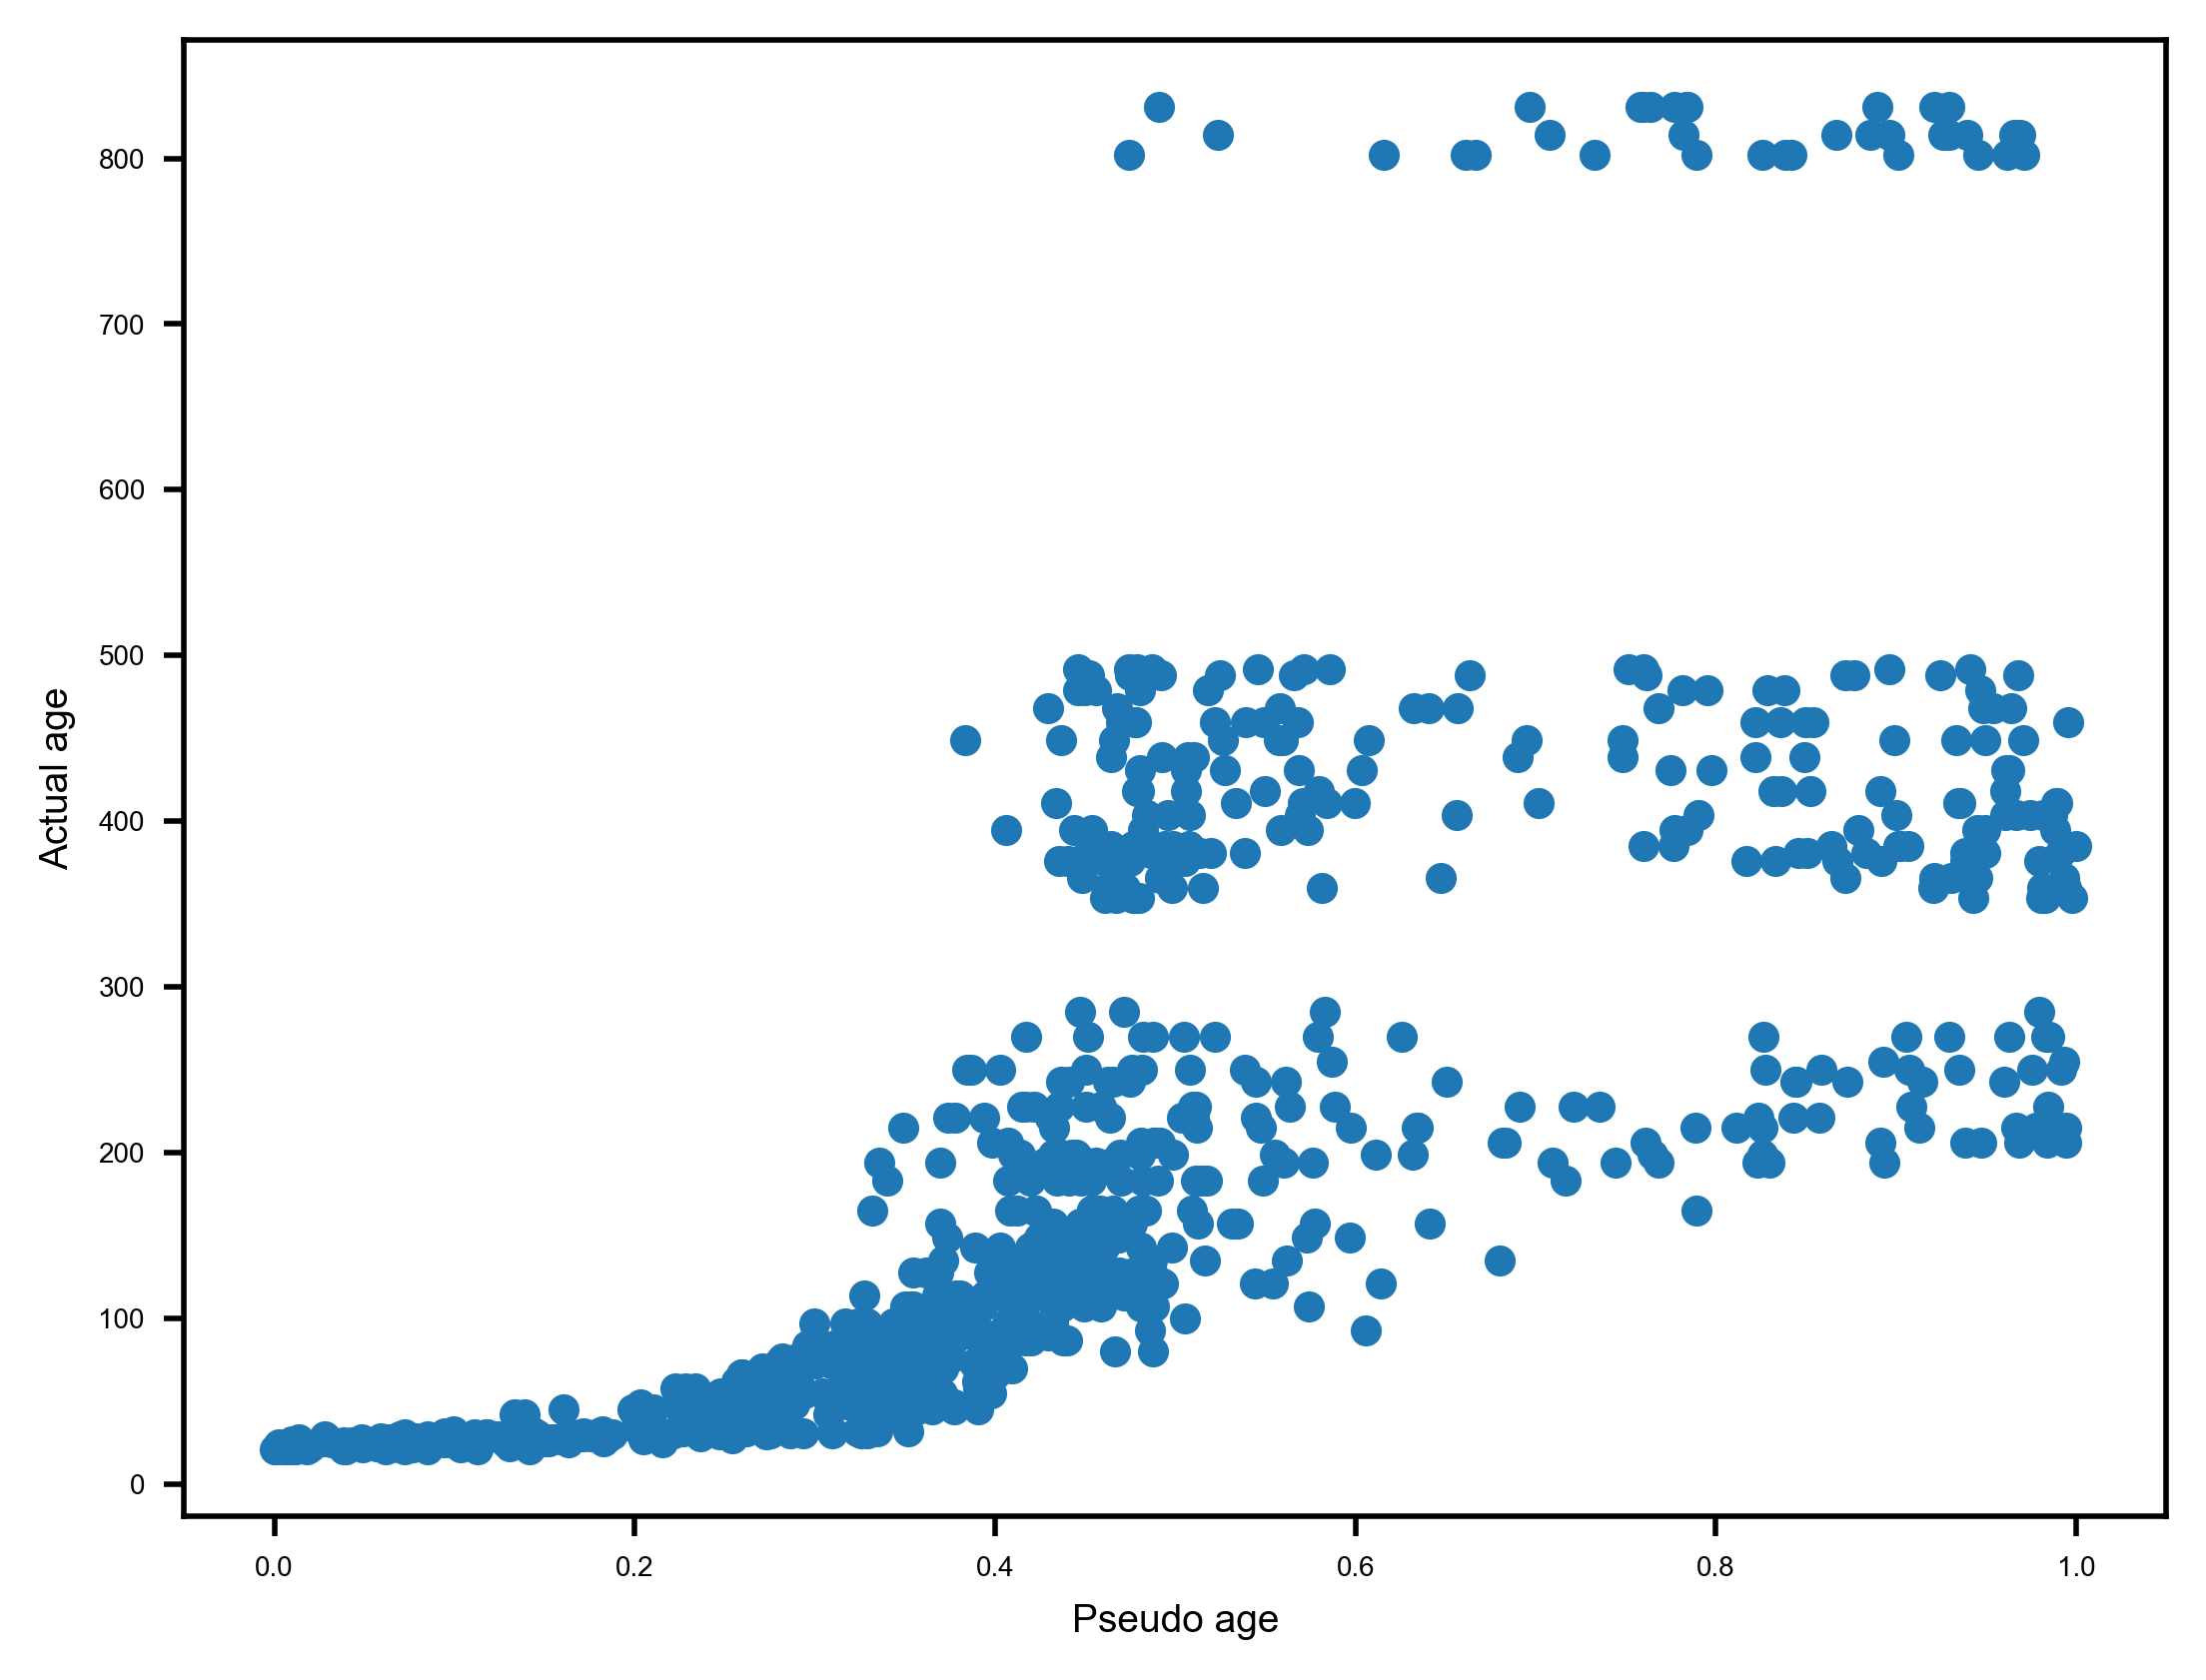

In [49]:
plt.scatter(1 - out[:, -1], df.index.get_level_values('age'))
plt.xlabel('Pseudo age')
plt.ylabel("Actual age")
print(spearmanr(1 - out[:, -1], df.index.get_level_values('age')))

In [50]:
enc = LabelEncoder().fit(df.index.get_level_values('mouse'))

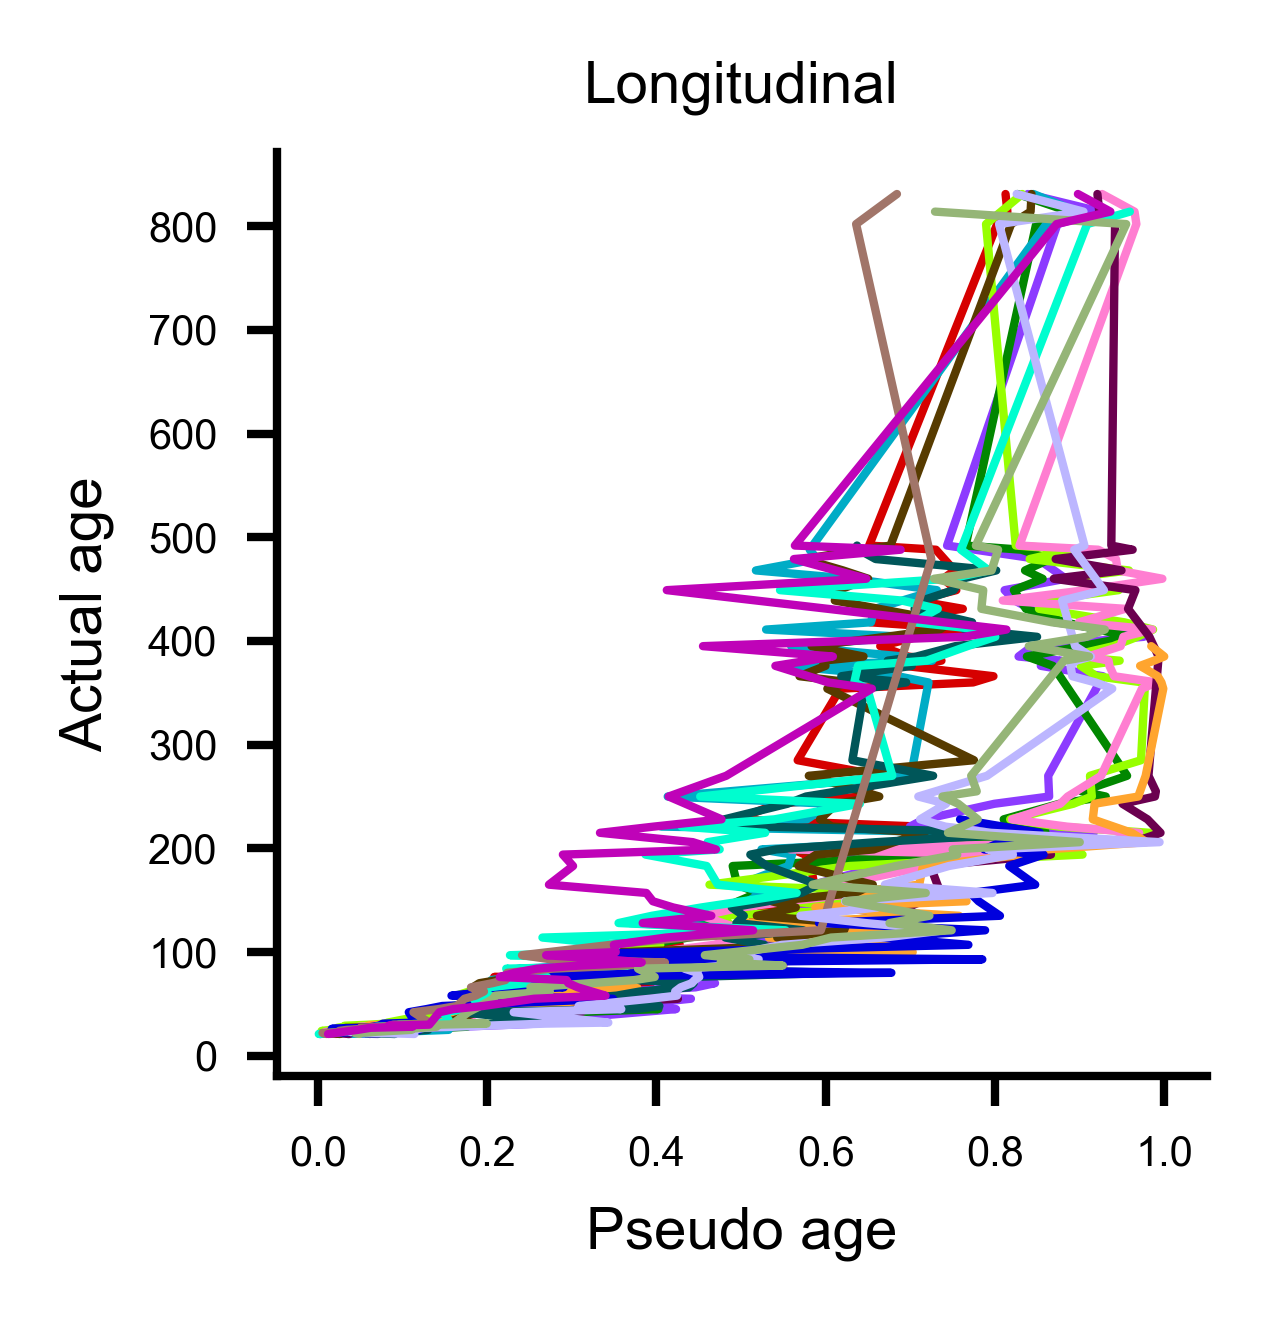

In [51]:
new_ser = pd.Series(rank_frac, index=df.index)
# new_ser = pd.Series(1 - out[:, -1], index=df.index)

figure(2, 2)
for mouse, s in new_ser.groupby('mouse'):
    l = enc.transform([mouse])[0]
    plt.plot(s, s.index.get_level_values('age'), c=cc.glasbey[l])

plt.xlabel('Pseudo age')
plt.ylabel("Actual age")
plt.title('Longitudinal')
sns.despine()

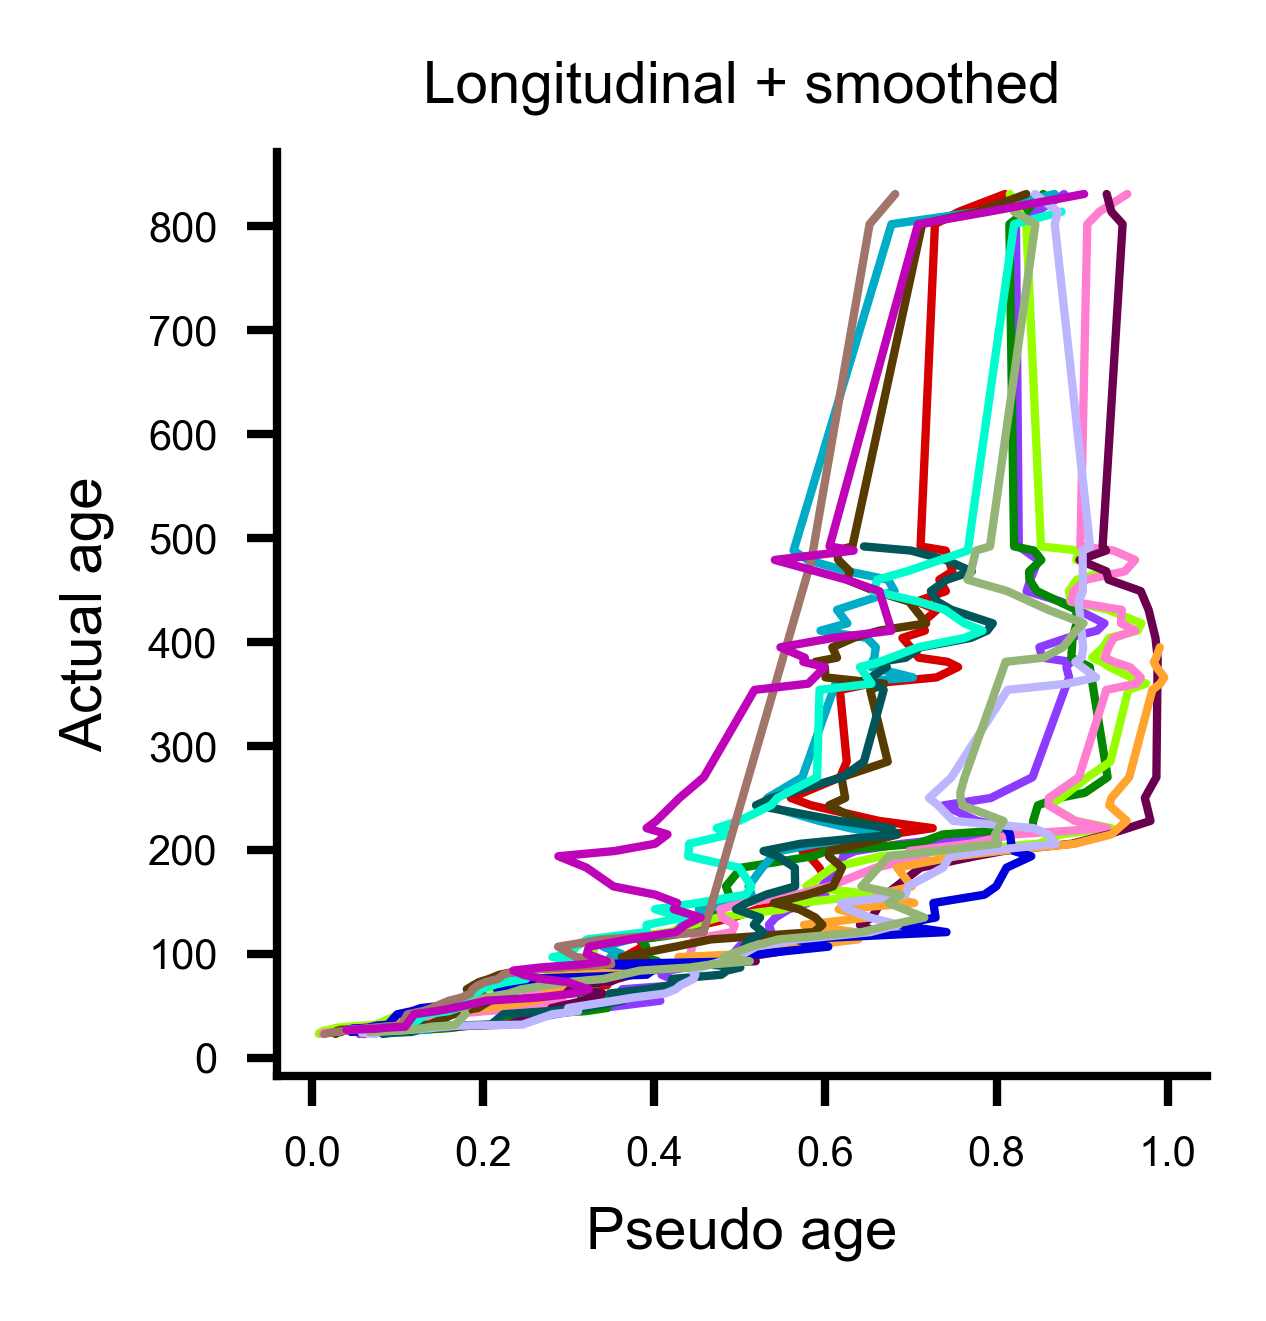

In [52]:
new_ser = pd.Series(rank_frac, index=df.index)
# new_ser = pd.Series(1 - out[:, -1], index=df.index)

figure(2, 2)
for mouse, s in new_ser.groupby('mouse'):
    l = enc.transform([mouse])[0]
    plt.plot(s.rolling(3).mean(), s.index.get_level_values('age'), c=cc.glasbey[l])

plt.xlabel('Pseudo age')
plt.ylabel("Actual age")
plt.title('Longitudinal + smoothed')
sns.despine()

In [53]:
# color by death
dead = [
    '02_04',
    '03_02',
    '03_03',
    '04_01',
    '02_03',
]

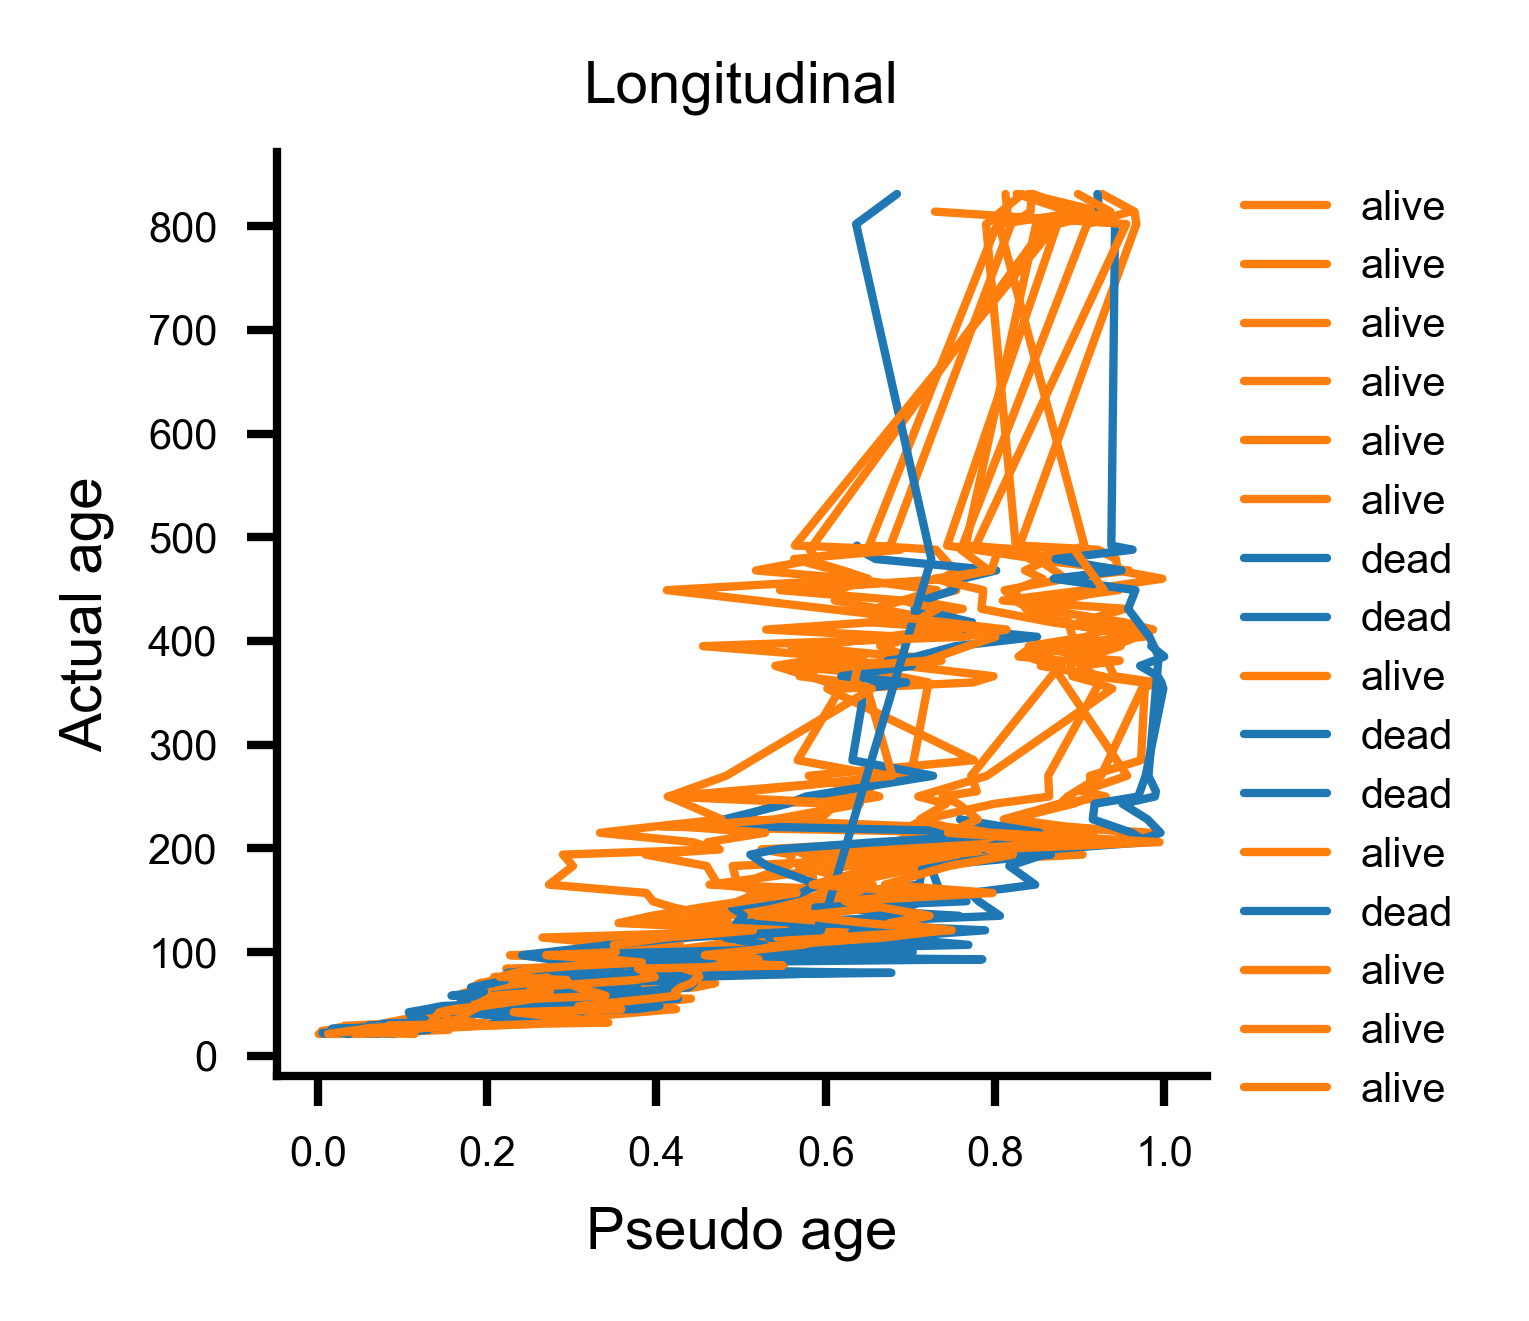

In [54]:
new_ser = pd.Series(rank_frac, index=df.index)
# new_ser = pd.Series(1 - out[:, -1], index=df.index)

figure(2, 2)
for mouse, s in new_ser.groupby('mouse'):
    l = enc.transform([mouse])[0]
    is_dead = mouse in dead
    label = 'dead' if is_dead else 'alive'
    plt.plot(s, s.index.get_level_values('age'), c='C0' if is_dead else 'C1', label=label)

legend()
plt.xlabel('Pseudo age')
plt.ylabel("Actual age")
plt.title('Longitudinal')
sns.despine()

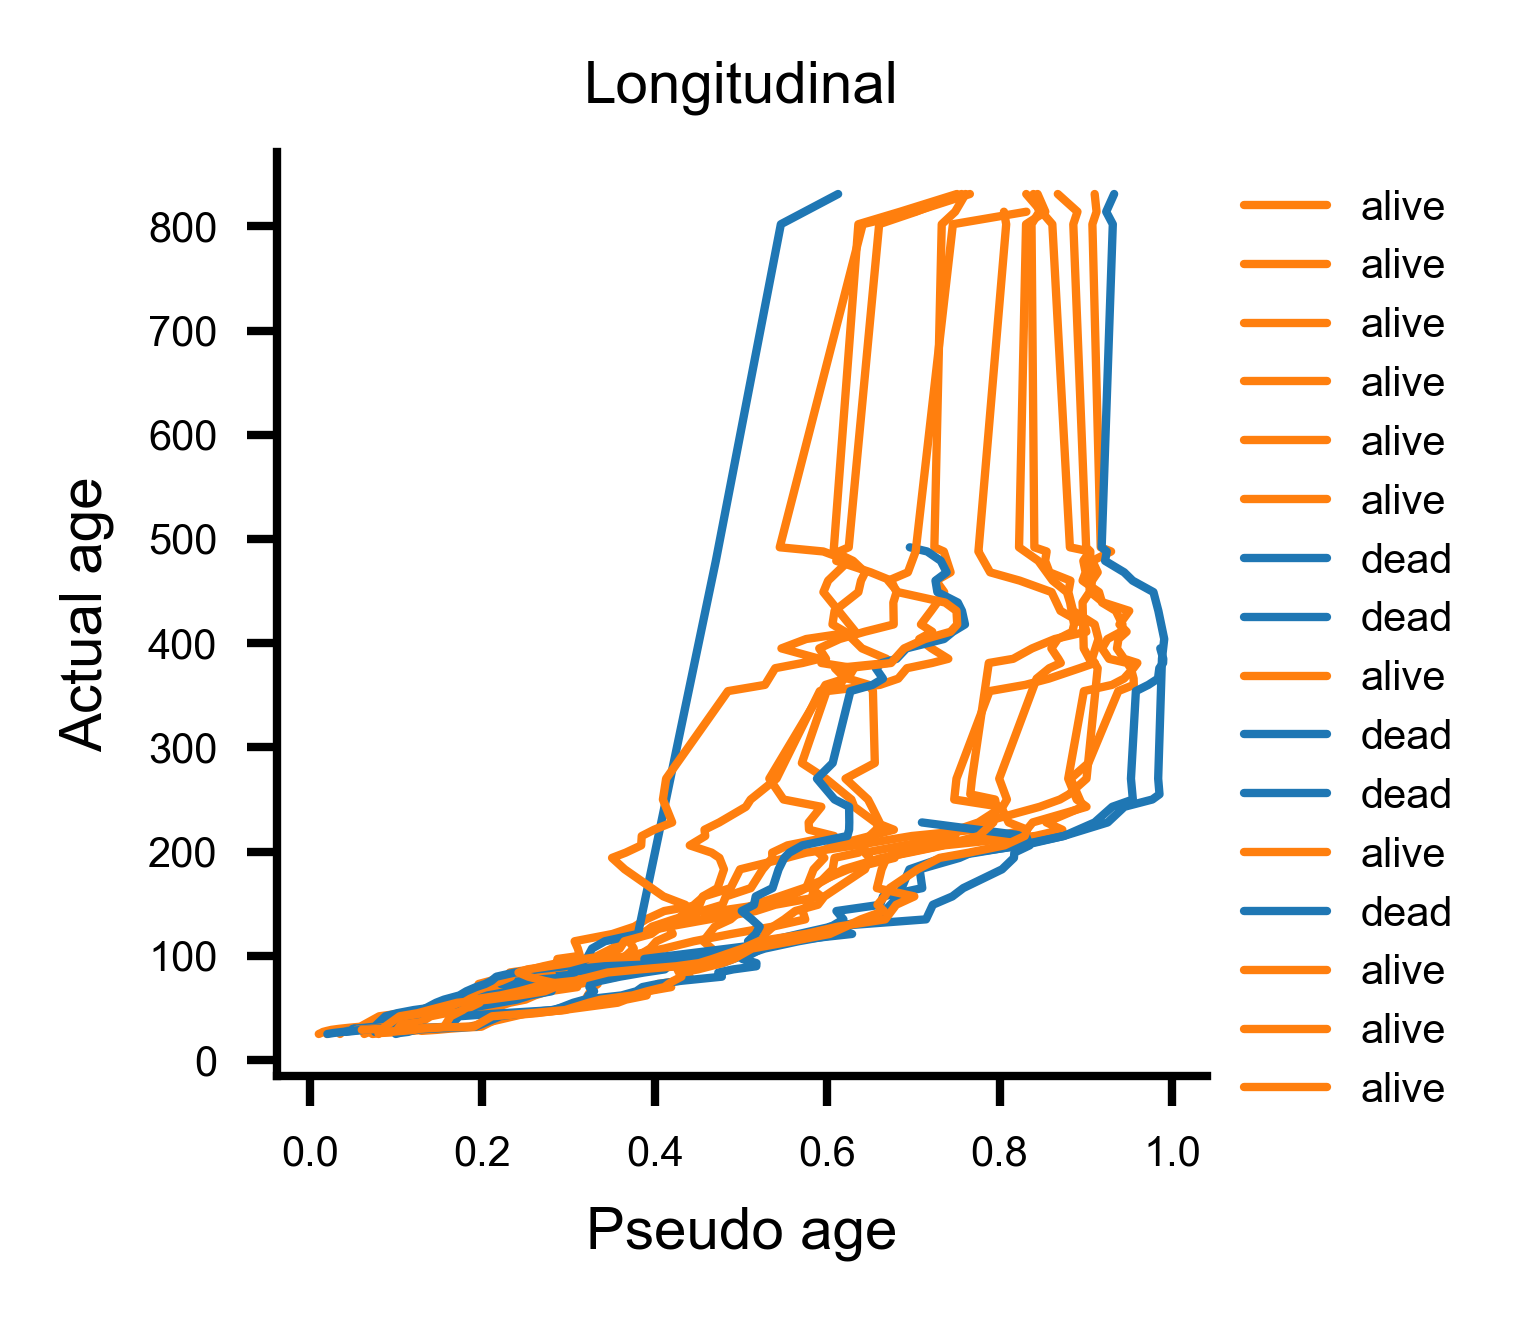

In [66]:
new_ser = pd.Series(rank_frac, index=df.index)
# new_ser = pd.Series(1 - out[:, -1], index=df.index)

figure(2, 2)
for mouse, s in new_ser.groupby("mouse"):
    l = enc.transform([mouse])[0]
    is_dead = mouse in dead
    label = "dead" if is_dead else "alive"
    plt.plot(
        s.rolling(5).mean(),
        s.index.get_level_values("age"),
        c="C0" if is_dead else "C1",
        label=label,
    )

legend()
plt.xlabel("Pseudo age")
plt.ylabel("Actual age")
plt.title("Longitudinal")
sns.despine()

In [56]:
df.iloc[0].name[1]

'01_01'

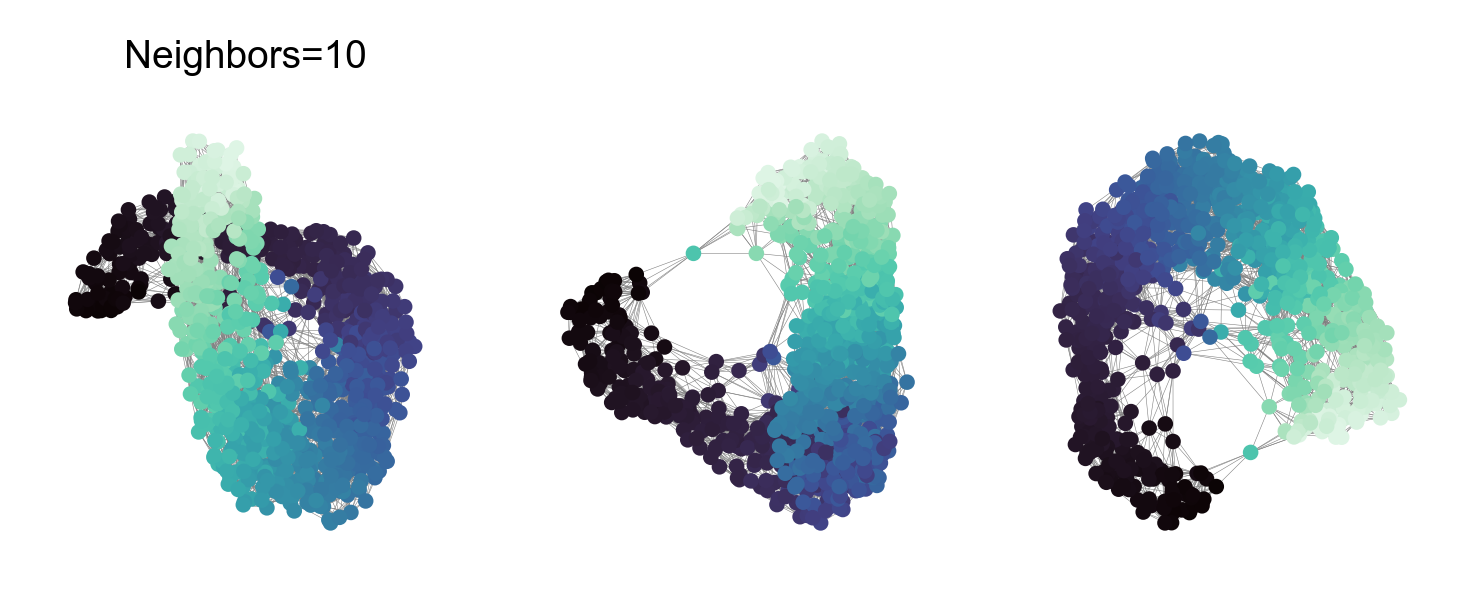

In [57]:
width = 1.5
n_cols = 3
indices = nn[:, :k_neigh + 1]

graph = nx.Graph()
edges = []
for row in indices:
    i = row[0]
    for j in row[1:]:
        edges.append((i, j, distances[i, j]))
graph.add_weighted_edges_from(edges)
# colors = [1 - out[i, -1] for i in graph.nodes]
colors = [rank_frac[i] for i in graph.nodes]

fig, ax = plt.subplots(1, n_cols, figsize=(n_cols * width, 1.5))
for i, a in enumerate(ax.flat):
    pos = nx.spring_layout(graph, seed=i)
    nx.draw(
        graph,
        pos=pos,
        node_size=4,
        width=0.1,
        edge_color="gray",
        node_color=colors,
        arrows=False,
        ax=a,
        cmap="mako",
    )
ax[0].set(title=f"Neighbors={k_neigh}")
plt.show()

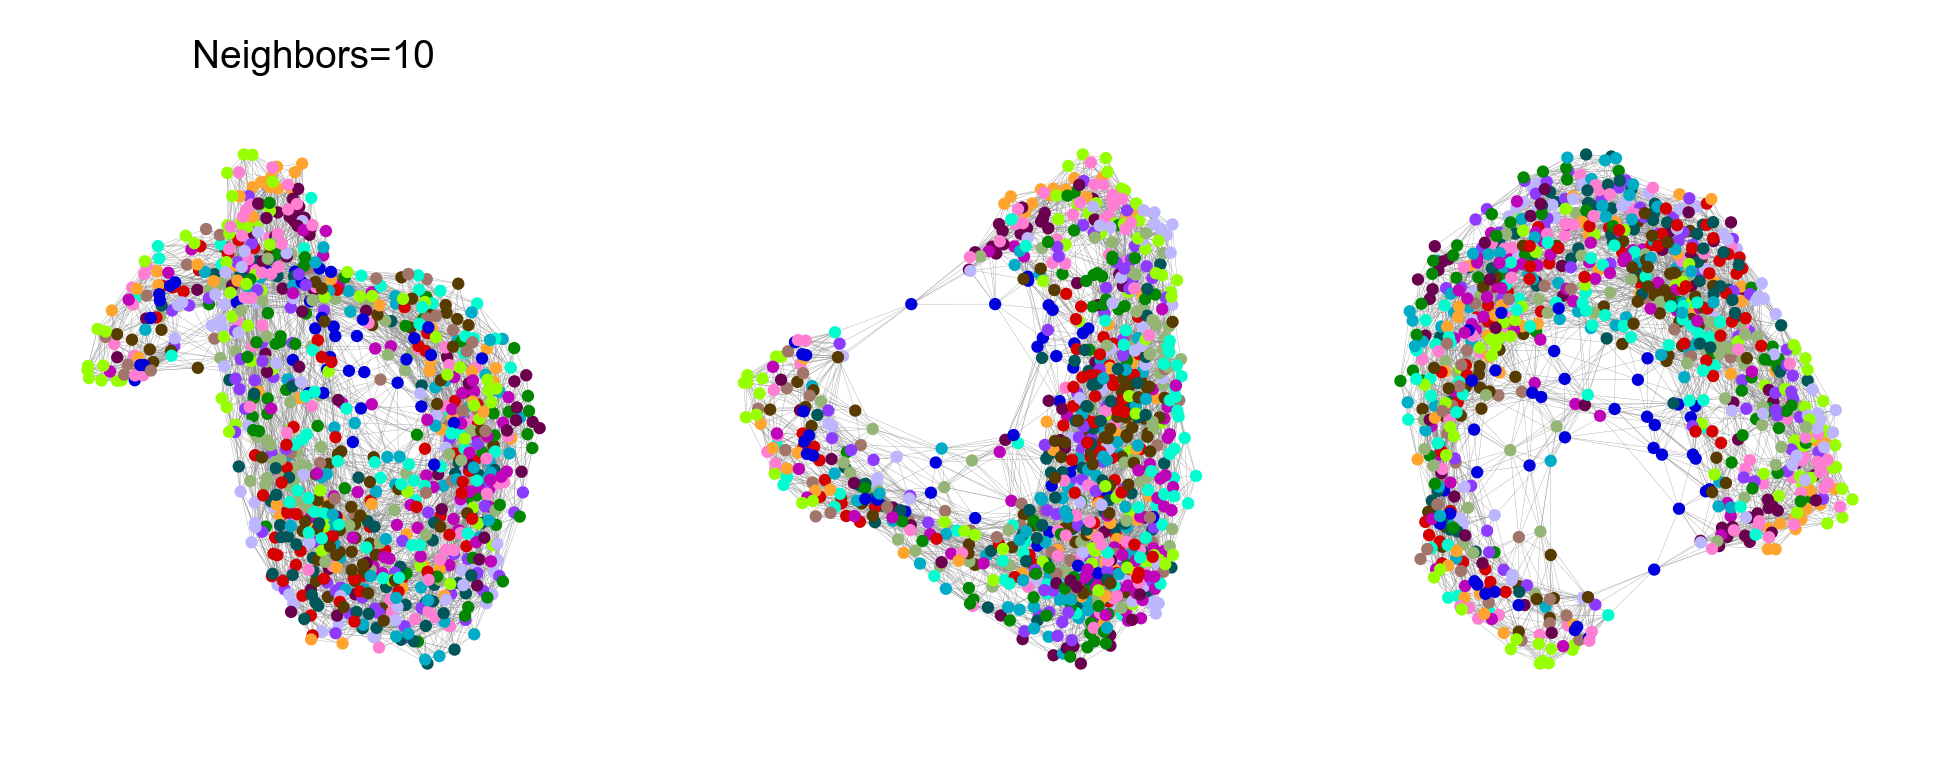

In [58]:
width = 2
n_cols = 3
indices = nn[:, :k_neigh + 1]

graph = nx.Graph()
edges = []
for row in indices:
    i = row[0]
    for j in row[1:]:
        edges.append((i, j, distances[i, j]))
graph.add_weighted_edges_from(edges)
# colors = [1 - out[i, -1] for i in graph.nodes]
colors = [cc.glasbey[enc.transform([mouse])[0]] for mouse in map(lambda i: df.iloc[i].name[1], graph.nodes)]
fig, ax = plt.subplots(1, n_cols, figsize=(n_cols * width, 2))
for i, a in enumerate(ax.flat):
    pos = nx.spring_layout(graph, seed=i)
    nx.draw(
        graph,
        pos=pos,
        node_size=2,
        width=0.05,
        edge_color="gray",
        node_color=colors,
        arrows=False,
        ax=a,
    )
ax[0].set(title=f"Neighbors={k_neigh}")
plt.show()

In [59]:
correlations = []
for k_neigh in trange(4, 16):
    a = np.zeros_like(distances)
    a[np.arange(len(a))[:, None], nn[:, :k_neigh + 1]] = 1 / k_neigh

    beta = 0.1
    smoother = np.eye(len(a)) * beta * a + (1 - beta) * a

    seed_idx = np.where(df.index.get_level_values('age') == df.index.get_level_values('age').min())[0]

    # pseudo_vals = np.zeros(len(a))
    # pseudo_vals[seed_idx] = 1
    pseudo_vals = 1 - _age.copy()

    n_iter = 5_000
    out = pseudo_vals.copy()

    for i in range(1, n_iter):
        out = mm_norm(smoother @ out)

    ranks = rankdata(1 - out)
    rank_frac = ranks / ranks.max()
    sr = spearmanr(rank_frac, df.index.get_level_values('age'))
    correlations.append(sr.statistic)
    print(k_neigh, spearmanr(rank_frac, df.index.get_level_values('age')))

  0%|          | 0/12 [00:00<?, ?it/s]

4 SignificanceResult(statistic=0.8893519423554248, pvalue=1.5483903876207e-311)
5 SignificanceResult(statistic=0.8866209578231763, pvalue=5.2889202022377035e-307)
6 SignificanceResult(statistic=0.8906519770936321, pvalue=9.766036811e-314)
7 SignificanceResult(statistic=0.8924152778910653, pvalue=9.1331e-317)
8 SignificanceResult(statistic=0.895477933593348, pvalue=3.75e-322)
9 SignificanceResult(statistic=0.8967223550175295, pvalue=0.0)
10 SignificanceResult(statistic=0.8984853886099005, pvalue=0.0)
11 SignificanceResult(statistic=0.8977782281006561, pvalue=0.0)
12 SignificanceResult(statistic=0.8967066443038441, pvalue=0.0)
13 SignificanceResult(statistic=0.8950371555189084, pvalue=2.273e-321)
14 SignificanceResult(statistic=0.8952776655028849, pvalue=8.5e-322)
15 SignificanceResult(statistic=0.895136853643532, pvalue=1.51e-321)


In [60]:
np.argmax(correlations)

6

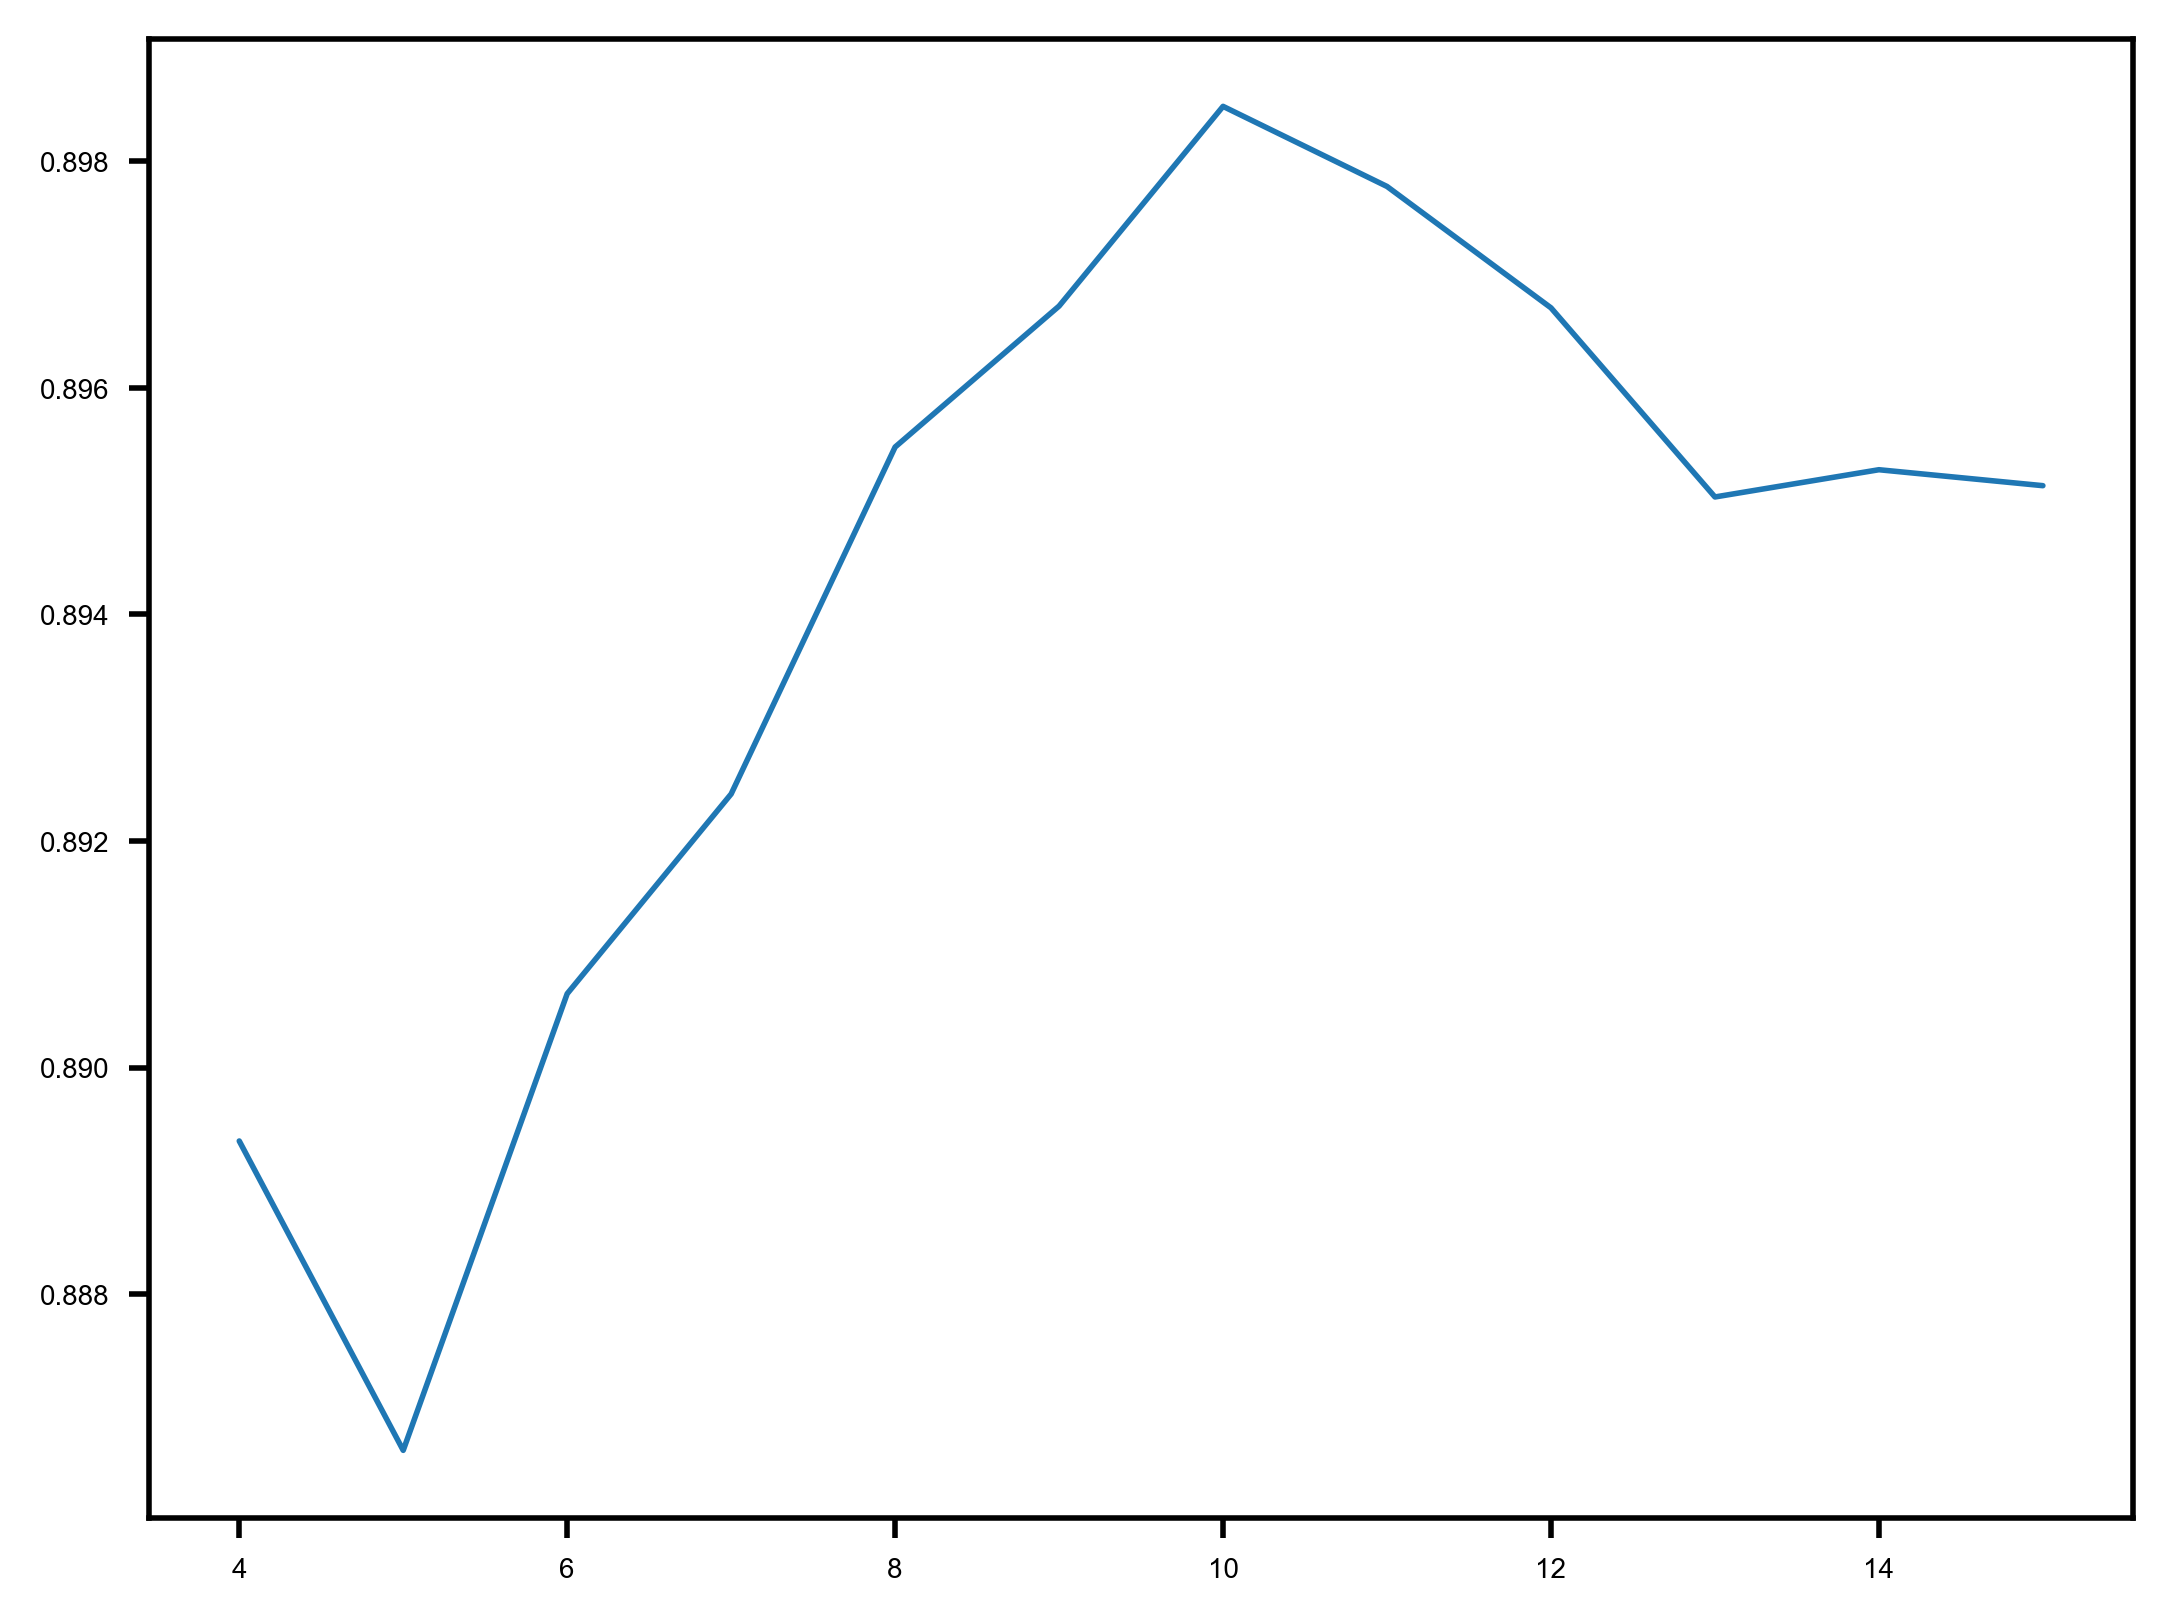

In [61]:
plt.plot(range(4, 16), correlations)

## Which correlation is better?

In [88]:
correlations = []
k_neigh = 8
pc_range = range(5, 251, 5)
for n_pcs in tqdm(pc_range):
    pcs = pca.fit_transform(df)[:, :n_pcs]
    distances = squareform(pdist(pcs, metric="euclidean"))
    nn = np.argsort(distances, axis=1)
    
    a = np.zeros_like(distances)
    a[np.arange(len(a))[:, None], nn[:, :k_neigh + 1]] = 1 / k_neigh

    beta = 0.1
    smoother = np.eye(len(a)) * beta * a + (1 - beta) * a

    seed_idx = np.where(df.index.get_level_values('age') == df.index.get_level_values('age').min())[0]

    pseudo_vals = np.zeros(len(a))
    pseudo_vals[seed_idx] = 1
    # pseudo_vals = 1 - _age.copy()

    n_iter = 5_000
    out = pseudo_vals.copy()

    for i in range(1, n_iter):
        out = mm_norm(smoother @ out)

    ranks = rankdata(1 - out)
    rank_frac = ranks / ranks.max()
    sr = spearmanr(rank_frac, df.index.get_level_values('age'))
    correlations.append(sr.statistic)
    print(n_pcs, spearmanr(rank_frac, df.index.get_level_values('age')))

  0%|          | 0/50 [00:00<?, ?it/s]

5 SignificanceResult(statistic=0.8951439643652319, pvalue=1.47e-321)
10 SignificanceResult(statistic=0.8905123838805751, pvalue=1.68770078267e-313)
15 SignificanceResult(statistic=0.8954783765943382, pvalue=3.75e-322)
20 SignificanceResult(statistic=0.8921173268009296, pvalue=2.9932825e-316)
25 SignificanceResult(statistic=0.8866179533445616, pvalue=5.349215756766182e-307)
30 SignificanceResult(statistic=0.8921591718990168, pvalue=2.53417574e-316)
35 SignificanceResult(statistic=0.8894507702026275, pvalue=1.0558322085156e-311)
40 SignificanceResult(statistic=0.8891615309862072, pvalue=3.2345712733226e-311)
45 SignificanceResult(statistic=0.8914102198246386, pvalue=4.938342986e-315)
50 SignificanceResult(statistic=0.889323637705023, pvalue=1.727730888325e-311)
55 SignificanceResult(statistic=0.8907262179552445, pvalue=7.2985142816e-314)
60 SignificanceResult(statistic=0.8912034012181939, pvalue=1.1170412567e-314)
65 SignificanceResult(statistic=0.8914877766405312, pvalue=3.63465575e-315

In [83]:
pd.Series(correlations, index=pc_range).rolling(7, center=True).mean().idxmax()

115

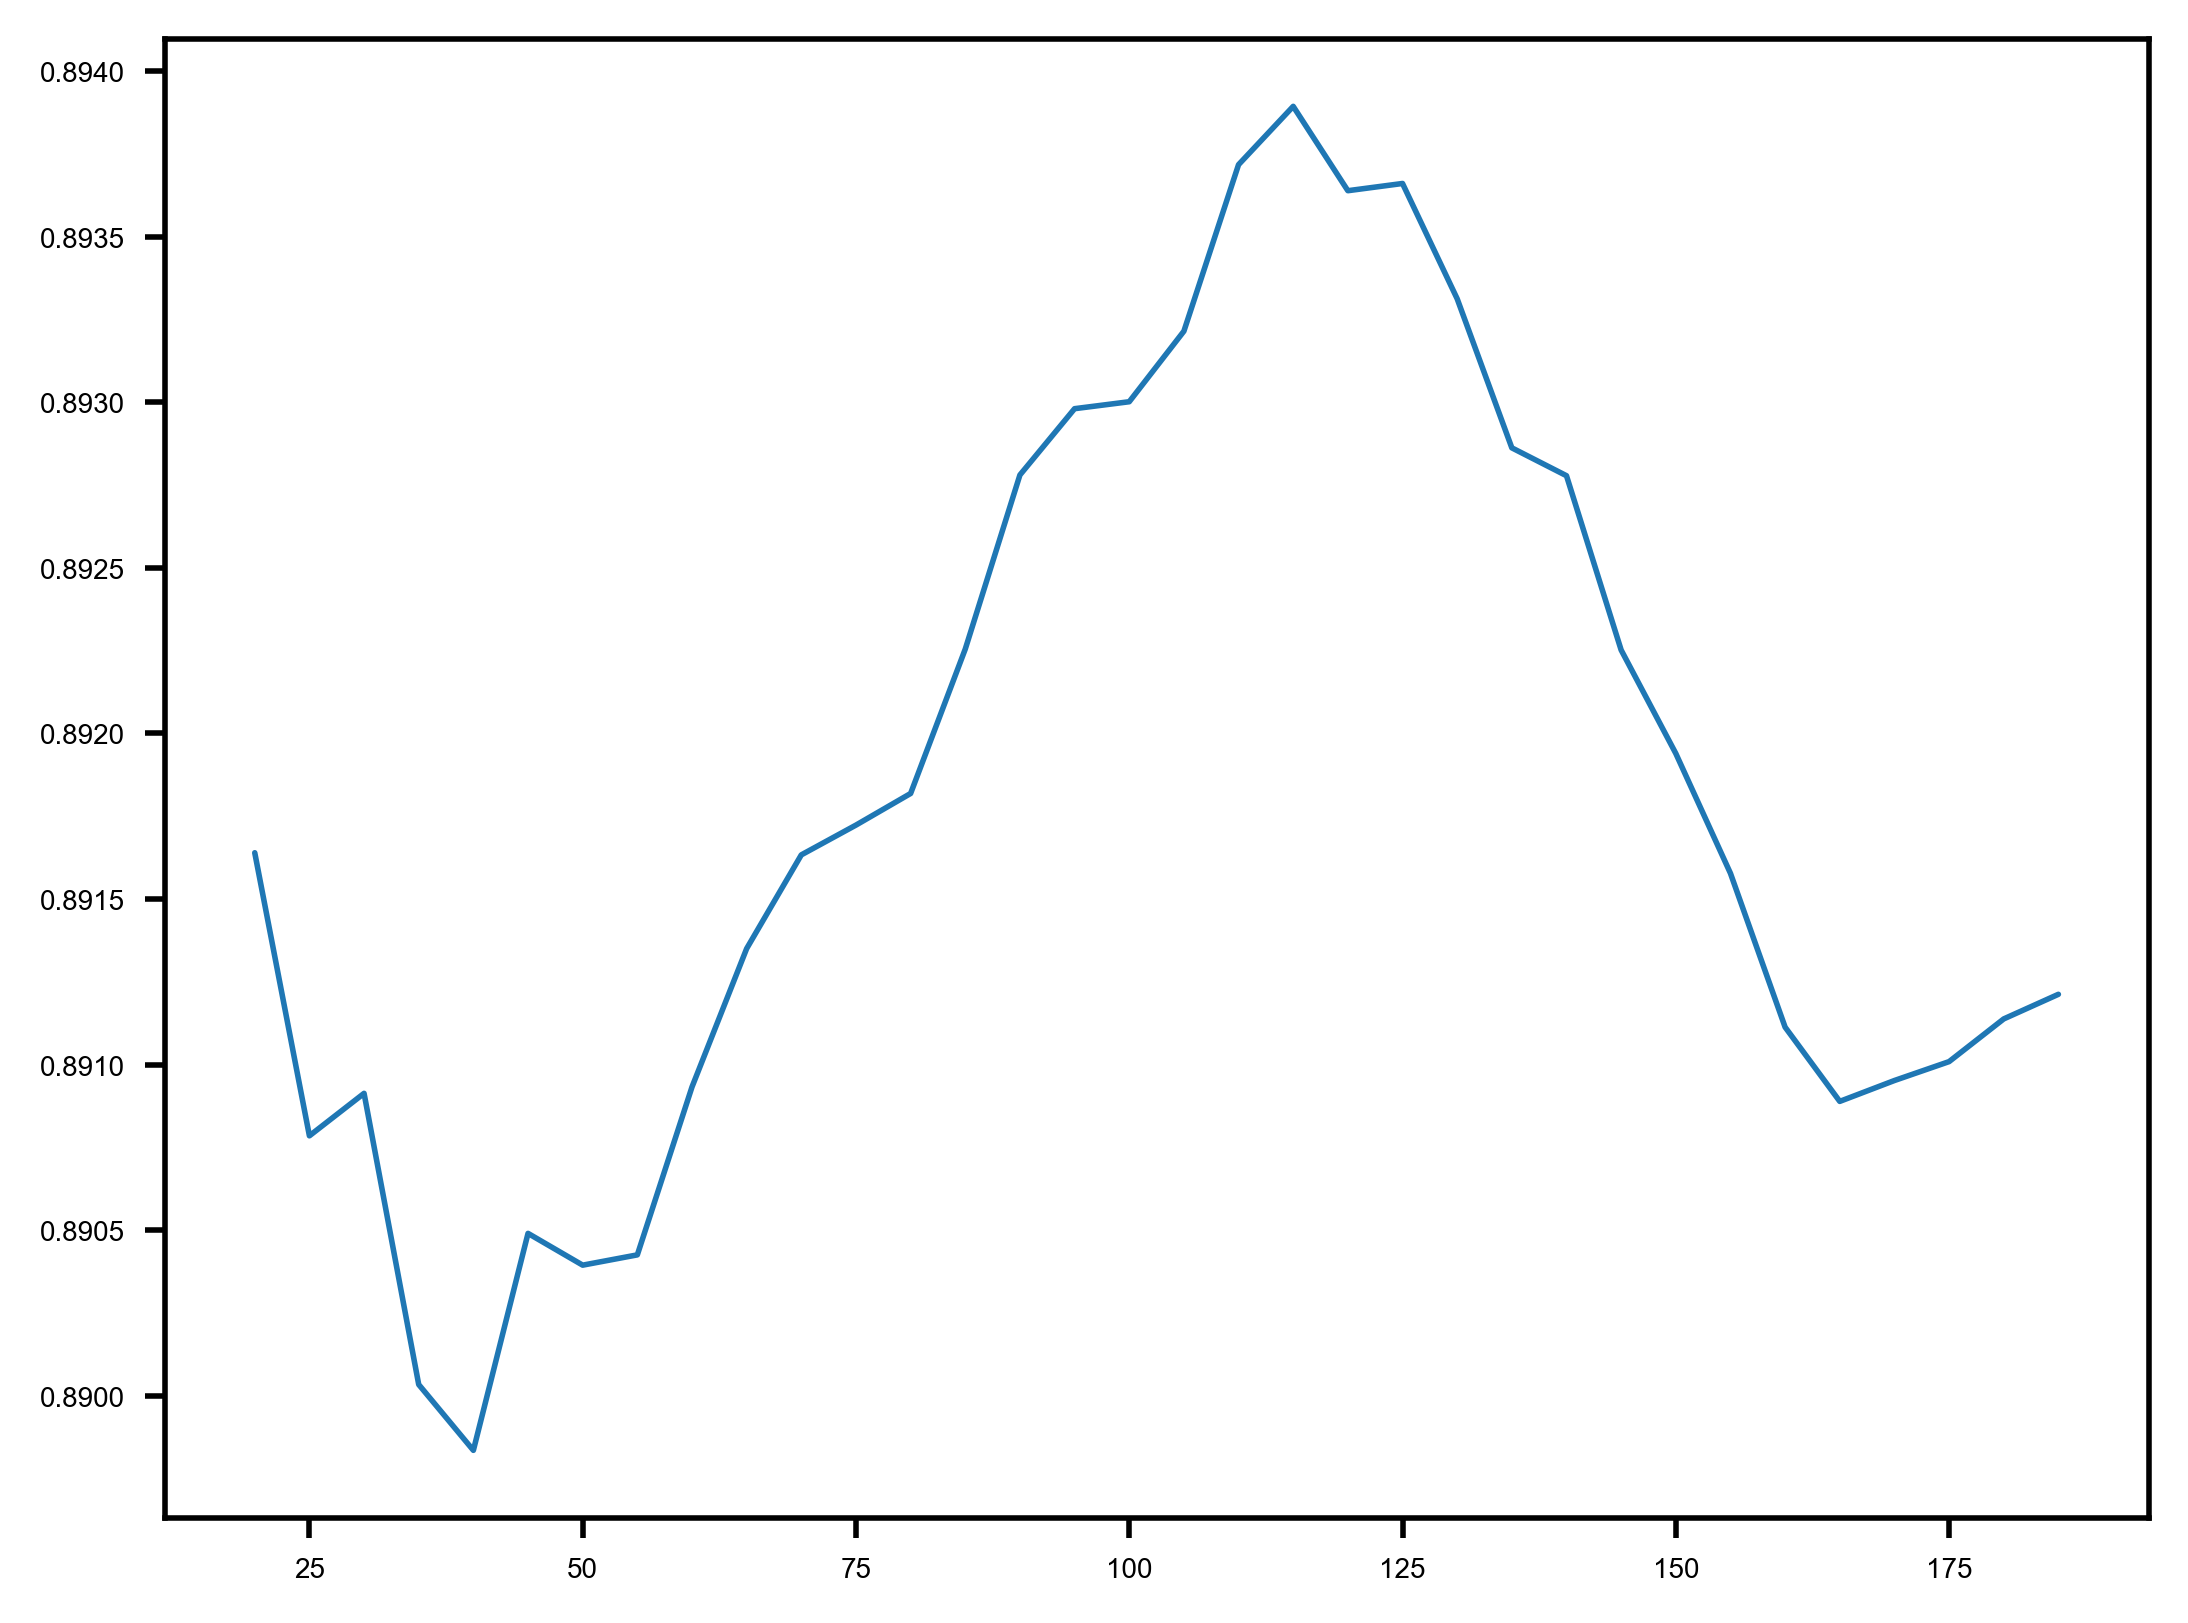

In [85]:
plt.plot(pc_range, pd.Series(correlations).rolling(7, center=True).mean())